In [1]:
%load_ext autoreload

import re, time, os, shutil, json, math
import numpy as np
import configdot
from tqdm import tqdm
import monai
from monai.data import DataLoader, Dataset, list_data_collate, decollate_batch

from collections import defaultdict
from IPython.core.debugger import set_trace

import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
import torch.optim as optim
from models.v2v import V2VModel

from losses import *
from dataset import setup_dataloaders, create_datafile, setup_datafiles, setup_transformations
from utils import save, get_capacity, calc_gradient_norm, get_label, get_latest_weights
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20

%autoreload 2

In [2]:
LOGDIR = '/workspace/RawData/FCDNet/logs/features_comparison/t1_all/'
log_dir_iter = os.listdir(LOGDIR)
log_dir_iter

['v2v-IN_autocast_DICE_lr-1e-3_nG-bs2-AUG-MASK-to-all-imgch-t1-all_scaler-trial1@26.07.2022-20',
 'v2v-IN_autocast_DICE_lr-1e-3_nG-bs2-AUG-MASK-to-all-imgch-t1-all_scaler-trial3@26.07.2022-20',
 'v2v-IN_autocast_DICE_lr-1e-3_nG-bs2-AUG-MASK-to-all-imgch-t1-all_scaler-trial2@26.07.2022-20',
 'v2v-IN_autocast_DICE_lr-1e-3_nG-bs2-AUG-MASK-to-all-imgch-t1-all_scaler-trial5@26.07.2022-20',
 'v2v-IN_autocast_DICE_lr-1e-3_nG-bs2-AUG-MASK-to-all-imgch-t1-all_scaler-trial4@29.07.2022-11']

In [3]:
logname = log_dir_iter[1]
logdir = os.path.join(LOGDIR, logname)

In [4]:
# val_preds_path = os.path.join(logdir, 'best_val_preds')
# best_val_preds = {}
# for label in os.listdir(val_preds_path):
#     val_preds_label_path = os.path.join(val_preds_path, label)
#     best_val_preds[label] = torch.load(val_preds_label_path)[0,0]

### Load model, setup dataloaders

In [5]:
config = configdot.parse_config(os.path.join(logdir,'config.ini'))

In [9]:
config.dataset.features

['image',
 't2',
 'flair',
 'blurring-t1',
 'blurring-t1',
 'blurring-t2',
 'blurring-Flair',
 'cr-t2',
 'cr-Flair',
 'thickness',
 'curv',
 'sulc',
 'variance',
 'entropy']

In [12]:
# essential for the proper samplers functioning
assert config.opt.val_batch_size == 1
DEVICE = 'cpu' # 'cuda:1' #'' # 'cpu'
device = torch.device(DEVICE)

#########
# MODEL #
#########
assert config.model.name == "v2v"
model = V2VModel(config).to(device)

###################
# CREATE DATASETS #
###################
train_loader, val_loader = setup_dataloaders(config)

print('val dataloder len: ', len(val_loader), 'train dataloder len: ', len(train_loader))

KeyError: 'Wrong feature_map name: entropy!'

# Forward pass

In [ ]:
SAVE_PREDS = False

if SAVE_PREDS:
    predictions_path = os.path.join(logdir, 'predictions')
    if not os.path.exists(predictions_path):
        os.makedirs(predictions_path)

In [10]:
best_val_preds['n23'].shape

(128, 128, 128)

0it [00:00, ?it/s]

Label: n51
n51 0.053197525441646576


/root/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


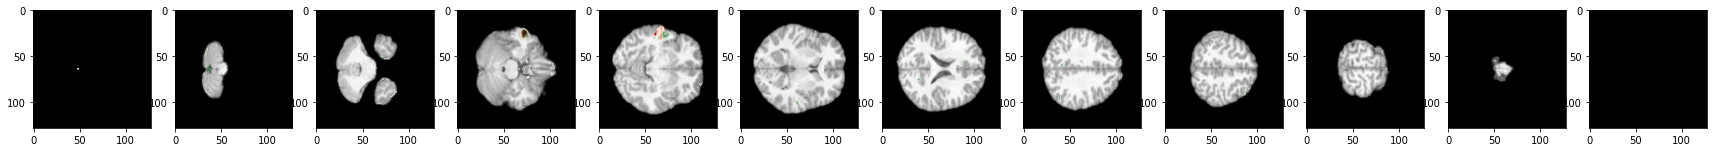

1it [00:07,  7.77s/it]

Label: n29
n29 0.06297028064727783


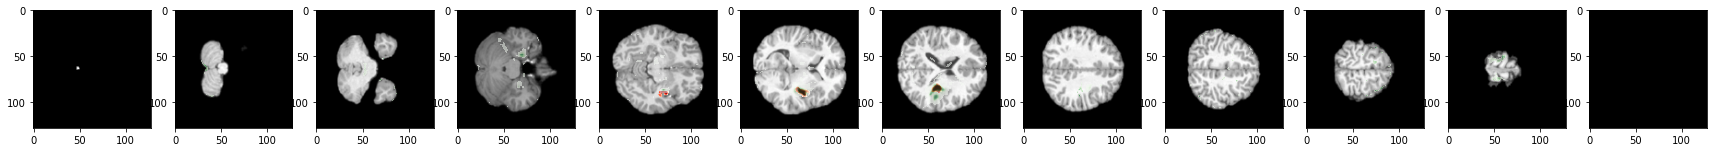

2it [00:15,  7.81s/it]

Label: n41
n41 0.06492658704519272


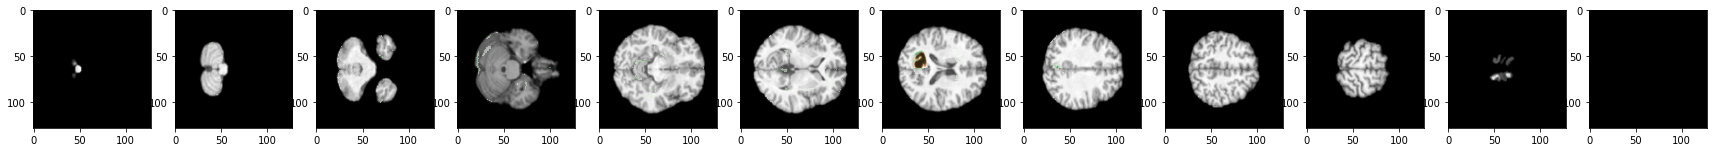

3it [00:23,  7.79s/it]

Label: G256
G256 0.010366629809141159


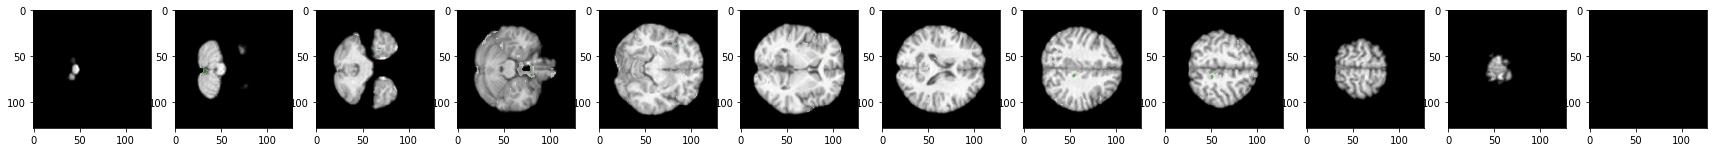

4it [00:31,  7.83s/it]

Label: n58
n58 0.0003356783417984843


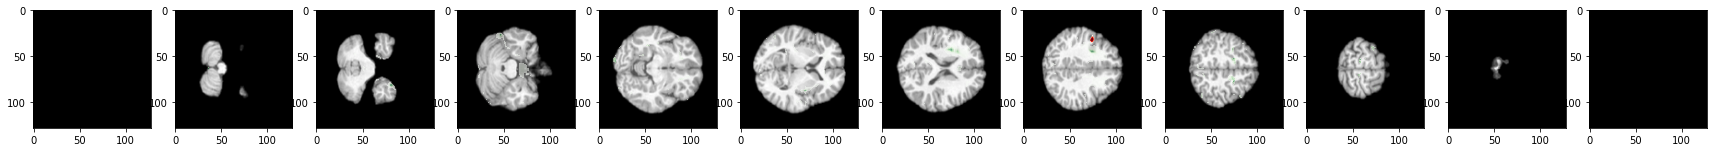

5it [00:39,  7.85s/it]

Label: G258
G258 0.010380593128502369


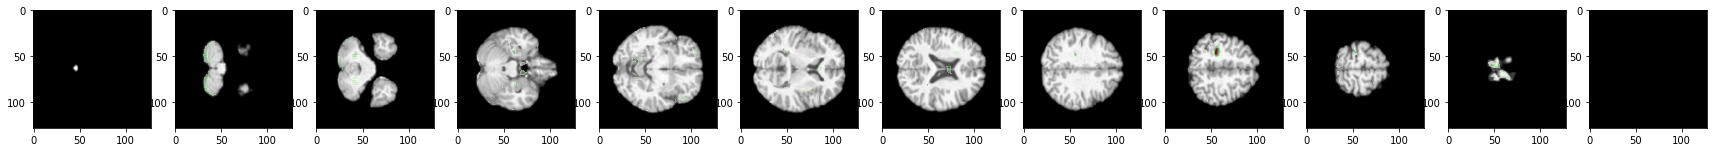

6it [00:46,  7.83s/it]

Label: n50
n50 0.014087468385696411


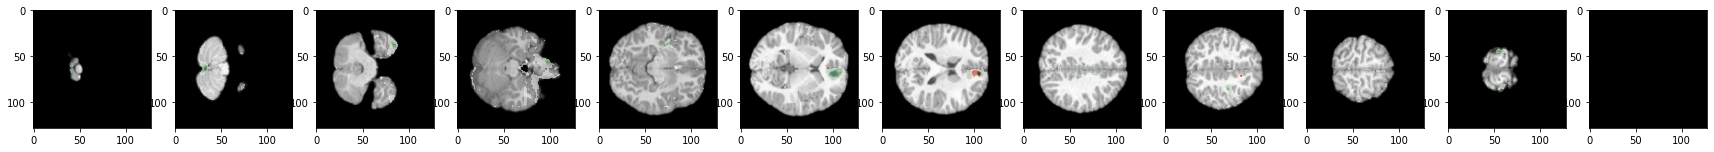

7it [00:55,  7.86s/it]

Label: n23
n23 0.01081821322441101


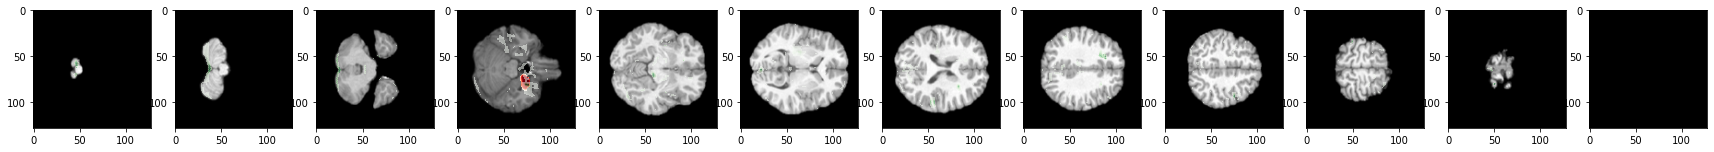

8it [01:02,  7.87s/it]

Label: n83
n83 0.0038536591455340385


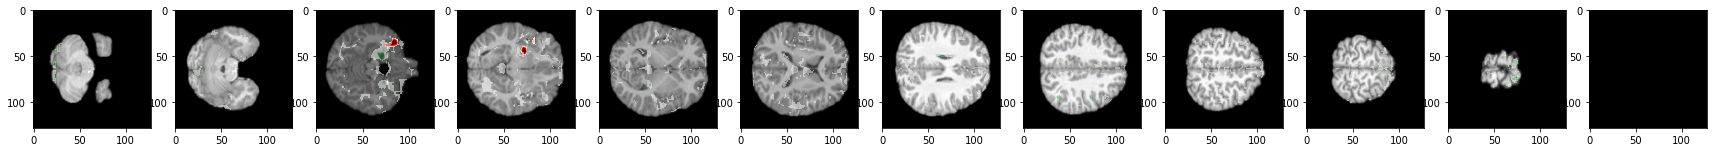

9it [01:11,  7.90s/it]

Label: G414
G414 0.046007029712200165


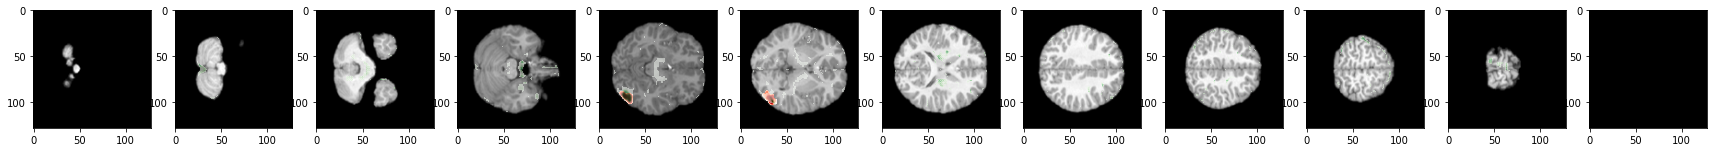

10it [01:18,  7.90s/it]


In [11]:
dataloader = val_loader

brains = {}
labels_gt = {}
metric_dict = defaultdict(list)
labels_pred = {}
labels_ref = {}

with torch.no_grad():

    # bs = 1
    # brain_tensor - [1,C,H,W,D]
    # mask_tensor - [1,1,H,W,D]
    # label_tensor - [1,1,H,W,D]
    
    #######################
    # ITERATE OVER BRAINS #
    #######################
    iterator = enumerate(dataloader)
   
    
    for iter_i, data_tensors in tqdm(iterator):
        brain_tensor, label_tensor = data_tensors['image'], data_tensors['seg']

        brain_tensor = brain_tensor.to(device)
        label_tensor = label_tensor.to(device)

        label = get_label(dataloader.dataset.data[iter_i]['seg'])
        label_tensor_predicted = torch.tensor(best_val_preds[label][None,None,...]).to(device)
        print(f'Label: {label}')

        cov = coverage(label_tensor_predicted, label_tensor).item()
        fp = false_positive(label_tensor_predicted, label_tensor).item()
        fn = false_negative(label_tensor_predicted, label_tensor).item()
        dice = dice_score(label_tensor_predicted.detach() > 1e-4, label_tensor.detach()).item()

        metric_dict['coverage'].append(cov) # a.k.a recall
        metric_dict['false_positive'].append(fp)
        metric_dict['false_negative'].append(fn)
        metric_dict['dice_score'].append(dice)
        
        print(label, dice)
        plt.figure("image", (30, 10))
        brains[label] = brain_tensor[0,0].detach().cpu().numpy()
        labels_gt[label] = label_tensor[0,0].detach().cpu().numpy()
        label_tensor_predicted = label_tensor_predicted[0,0].detach().cpu()
        labels_pred[label] = label_tensor_predicted.numpy()
        labels_pred[label] = labels_pred[label]
        
        masked_labels_pred = np.ma.masked_where(labels_pred[label] < 1e-4, labels_pred[label])
        masked_labels_gt = np.ma.masked_where(labels_gt[label] < 1e-4, labels_gt[label])
        
        for i in range(12):
            plt.subplot(1, 12, i+1)
            ind = math.floor(127 * (i / 12))
            plt.imshow(brains[label][:,:,ind], cmap='gray')
            plt.imshow(masked_labels_gt[:,:,ind], cmap='Reds')
            plt.imshow(masked_labels_pred[:,:,ind], cmap='Greens', alpha=0.5)
        
        if SAVE_PREDS:
            torch.save(label_tensor_predicted, os.path.join(predictions_path, f'{label}'))
        plt.show()

In [12]:
get_latest_weights(logdir)

'/workspace/RawData/FCDNet/logs/features_comparison/v2v-IN_autocast_DICE_lr-1e-3_nG-bs2-AUG-noensuretyped-MASK-to-all-imgch-t1+ALL@02.07.2022-08/checkpoints/weights_254.pth'

In [13]:
best_model = V2VModel(config)

In [100]:
model_dict = torch.load(get_latest_weights(logdir))
best_model.load_state_dict(model_dict['model_state'])
best_model.eval()

V2VModel(
  (front_layers): Sequential(
    (0): Basic3DBlock(
      (block): Sequential(
        (0): Conv3d(11, 16, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3))
        (1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): Res3DBlock(
      (res_branch): Sequential(
        (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (skip_con): Sequential(
        (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Fal

In [101]:
test_data_indcs = ['6', '7', '40', '45', '75', '84', '14', '42', '68NS', '71NS']
feat_params = config.dataset.features
test_files = create_datafile(test_data_indcs, feat_params, mask=True)

In [102]:
_, val_trans =  setup_transformations(config)
test_ds = monai.data.Dataset(data=test_files[0], transform=val_trans)
test_loader = DataLoader(test_ds, 
                        batch_size=1, 
                        num_workers=0, 
                        collate_fn=list_data_collate,
                        shuffle=False # important not to shuffle, to ensure label correspondence
                        )

In [103]:
check_data = monai.utils.misc.first(test_loader)

In [104]:
check_data['seg'].shape, check_data['image'].shape

(torch.Size([1, 1, 128, 128, 128]), torch.Size([1, 11, 128, 128, 128]))

0it [00:00, ?it/s]

Label: 6
torch.Size([1, 1, 128, 128, 128])
6 0.003051957581192255


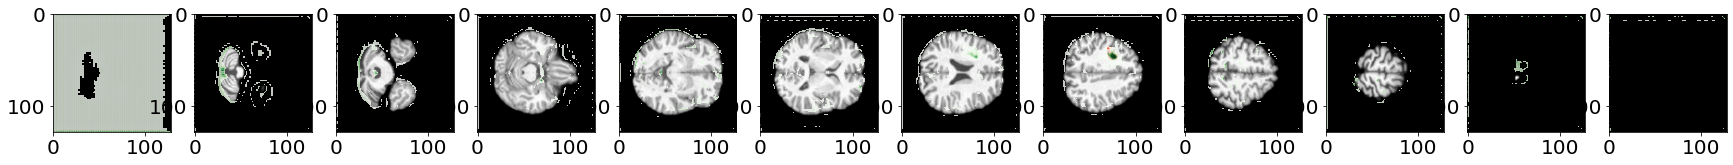

1it [00:11, 11.68s/it]

Label: 7
torch.Size([1, 1, 128, 128, 128])
7 0.01416052971035242


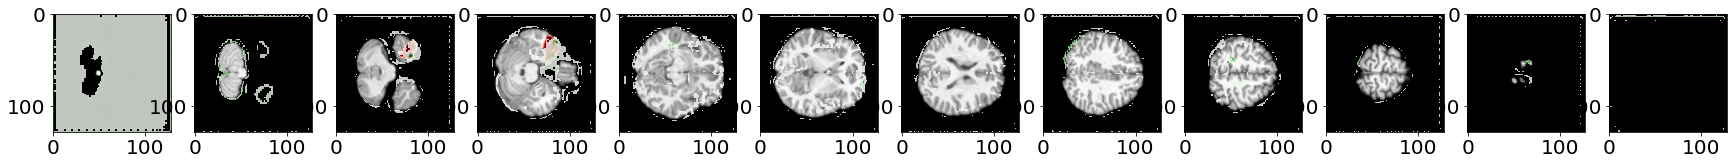

2it [00:23, 11.75s/it]

Label: 40
torch.Size([1, 1, 128, 128, 128])
40 0.0006181981298141181


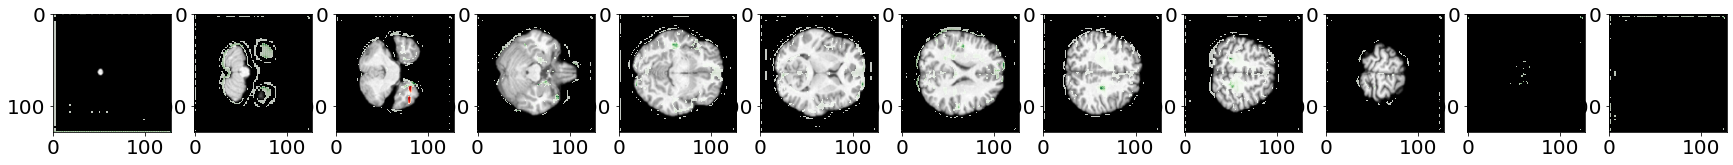

3it [00:34, 11.63s/it]

Label: 45
torch.Size([1, 1, 128, 128, 128])
45 0.00016597576905041933


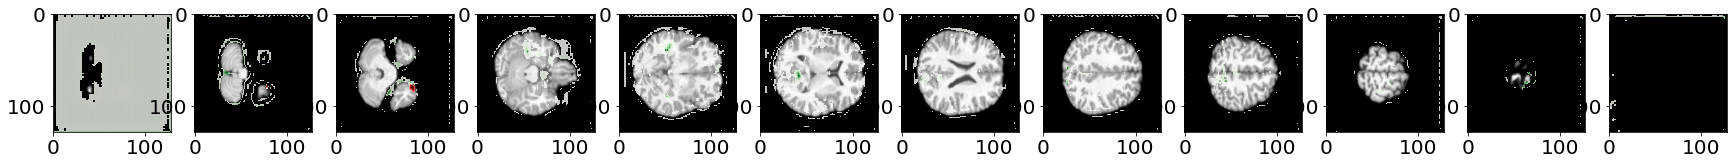

4it [00:46, 11.65s/it]

Label: 75
torch.Size([1, 1, 128, 128, 128])
75 0.0008307405514642596


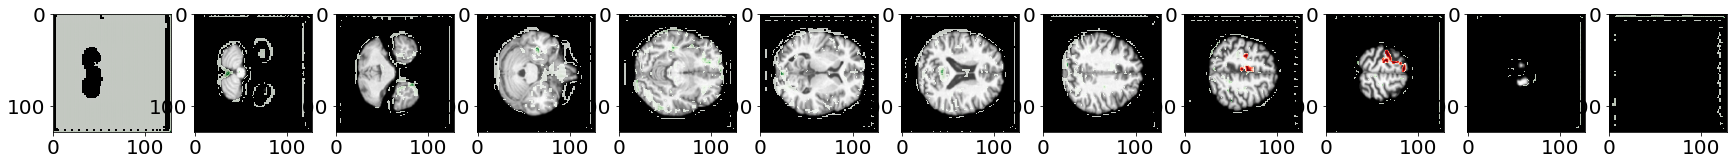

5it [00:58, 11.76s/it]

Label: 84
torch.Size([1, 1, 128, 128, 128])
84 0.00031814398244023323


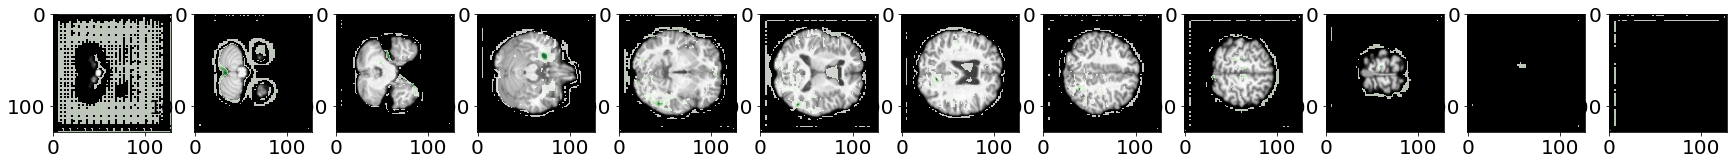

6it [01:10, 11.83s/it]

Label: 14
torch.Size([1, 1, 128, 128, 128])
14 0.0026800509076565504


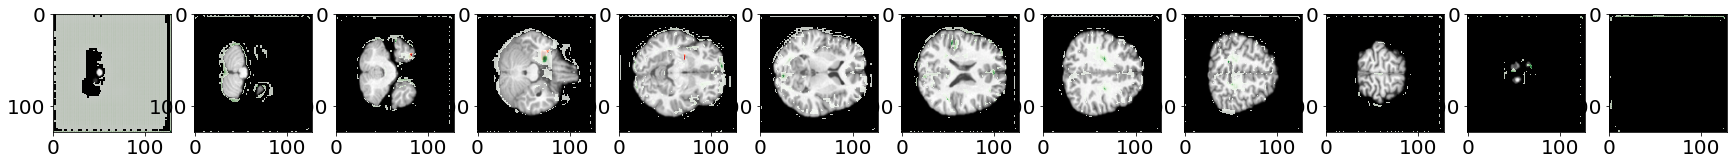

7it [01:23, 11.91s/it]

Label: 42
torch.Size([1, 1, 128, 128, 128])
42 0.00016184232663363218


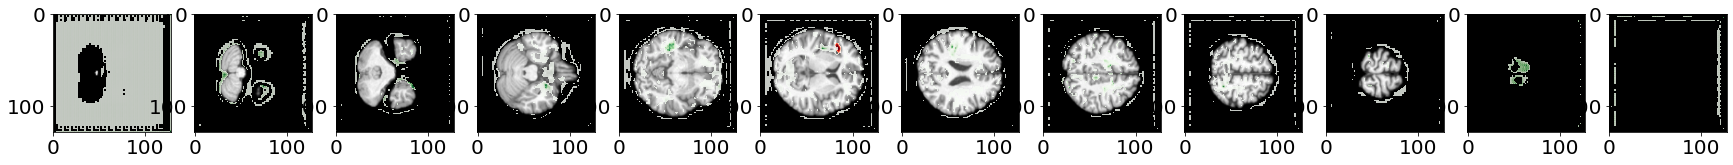

8it [01:35, 11.97s/it]

Label: 68NS
torch.Size([1, 1, 128, 128, 128])
68NS 0.0038965751882642508


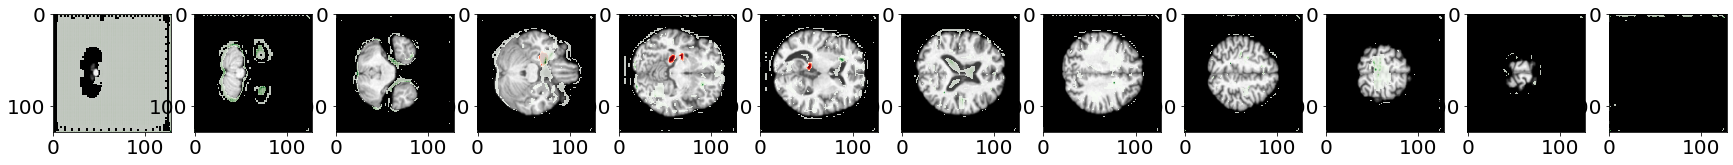

9it [01:48, 12.03s/it]

Label: 71NS
torch.Size([1, 1, 128, 128, 128])
71NS 0.012848848477005959


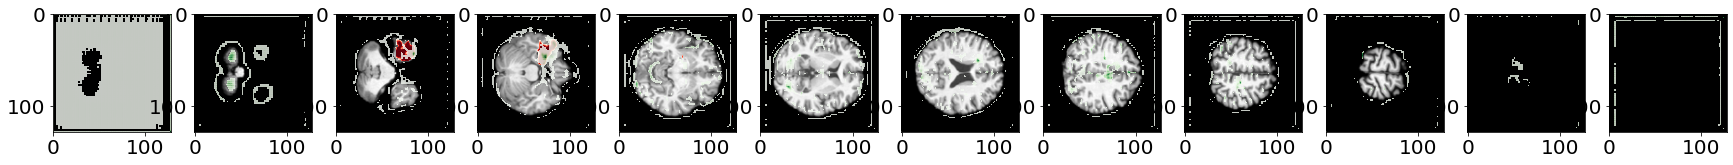

10it [02:00, 12.04s/it]


In [108]:
dataloader = test_loader

brains = {}
labels_gt = {}
metric_dict = defaultdict(list)
labels_pred = {}
labels_ref = {}

with torch.no_grad():

    # bs = 1
    # brain_tensor - [1,C,H,W,D]
    # mask_tensor - [1,1,H,W,D]
    # label_tensor - [1,1,H,W,D]
    
    #######################
    # ITERATE OVER BRAINS #
    #######################
    iterator = enumerate(dataloader)
   
    
    for iter_i, data_tensors in tqdm(iterator):
        brain_tensor, label_tensor = data_tensors['image'], data_tensors['seg']

        brain_tensor = brain_tensor.to(device)
        label_tensor = label_tensor.to(device)

        label = get_label(dataloader.dataset.data[iter_i]['seg'])
        print(f'Label: {label}')
        
        # forward pass
        label_tensor_forward = best_model(brain_tensor) # -> [1,1,ps,ps,ps]
        label_tensor_predicted = label_tensor_forward.to(device)
        
        print(label_tensor_forward.shape)
        cov = coverage(label_tensor_predicted, label_tensor).item()
        fp = false_positive(label_tensor_predicted, label_tensor).item()
        fn = false_negative(label_tensor_predicted, label_tensor).item()
        dice = dice_score(label_tensor_predicted.detach() > 1e-4, label_tensor.detach()).item()

        metric_dict['coverage'].append(cov) # a.k.a recall
        metric_dict['false_positive'].append(fp)
        metric_dict['false_negative'].append(fn)
        metric_dict['dice_score'].append(dice)
        
        print(label, dice)
        plt.figure("image", (30, 10))
        brains[label] = brain_tensor[0,0].detach().cpu().numpy()
        labels_gt[label] = label_tensor[0,0].detach().cpu().numpy()
        label_tensor_predicted = label_tensor_predicted[0,0].detach().cpu()
        labels_pred[label] = label_tensor_predicted.numpy()
        labels_pred[label] = labels_pred[label]
        
        masked_labels_pred = np.ma.masked_where(labels_pred[label] < 1e-4, labels_pred[label])
        masked_labels_gt = np.ma.masked_where(labels_gt[label] < 1e-4, labels_gt[label])
        
        #masked_labels_pred = labels_pred[label]
        #masked_labels_gt = labels_gt[label]
        
        for i in range(12):
            plt.subplot(1, 12, i+1)
            ind = math.floor(127 * (i / 12))
            plt.imshow(brains[label][:,:,ind], cmap='gray')
            plt.imshow(masked_labels_gt[:,:,ind], cmap='Reds')
            plt.imshow(masked_labels_pred[:,:,ind], cmap='Greens', alpha=0.8)
        
        if SAVE_PREDS:
            torch.save(label_tensor_predicted, os.path.join(predictions_path, f'{label}'))
        plt.show()

In [29]:
# plt.ion()
# plt.figure(figsize=(10,5),dpi=200)
# plt.bar(metric_dict['dice_score'].keys(), metric_dict['dice_score'].values(), alpha=0.5, label='V2V')
# exp_name = logdir.split('/')[1]
# plt.title(f'Val')
# plt.ylabel('Dice score')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [30]:
# plt.ion()
# plt.figure(figsize=(10,5),dpi=200)
# plt.bar(metric_dict['coverage'].keys(), metric_dict['coverage'].values(), alpha=0.5, label='V2V')
# exp_name = logdir.split('/')[1]
# plt.title(f'Val')
# plt.ylabel('Recall')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [38]:
# dices = np.array(list(metric_dict['dice_score'].values()))
# labels = np.array(list(metric_dict['dice_score'].keys()))

In [43]:
image_path = os.path.join(logdir, 'images_val')
if not os.path.exists(image_path):
    os.makedirs(image_path)

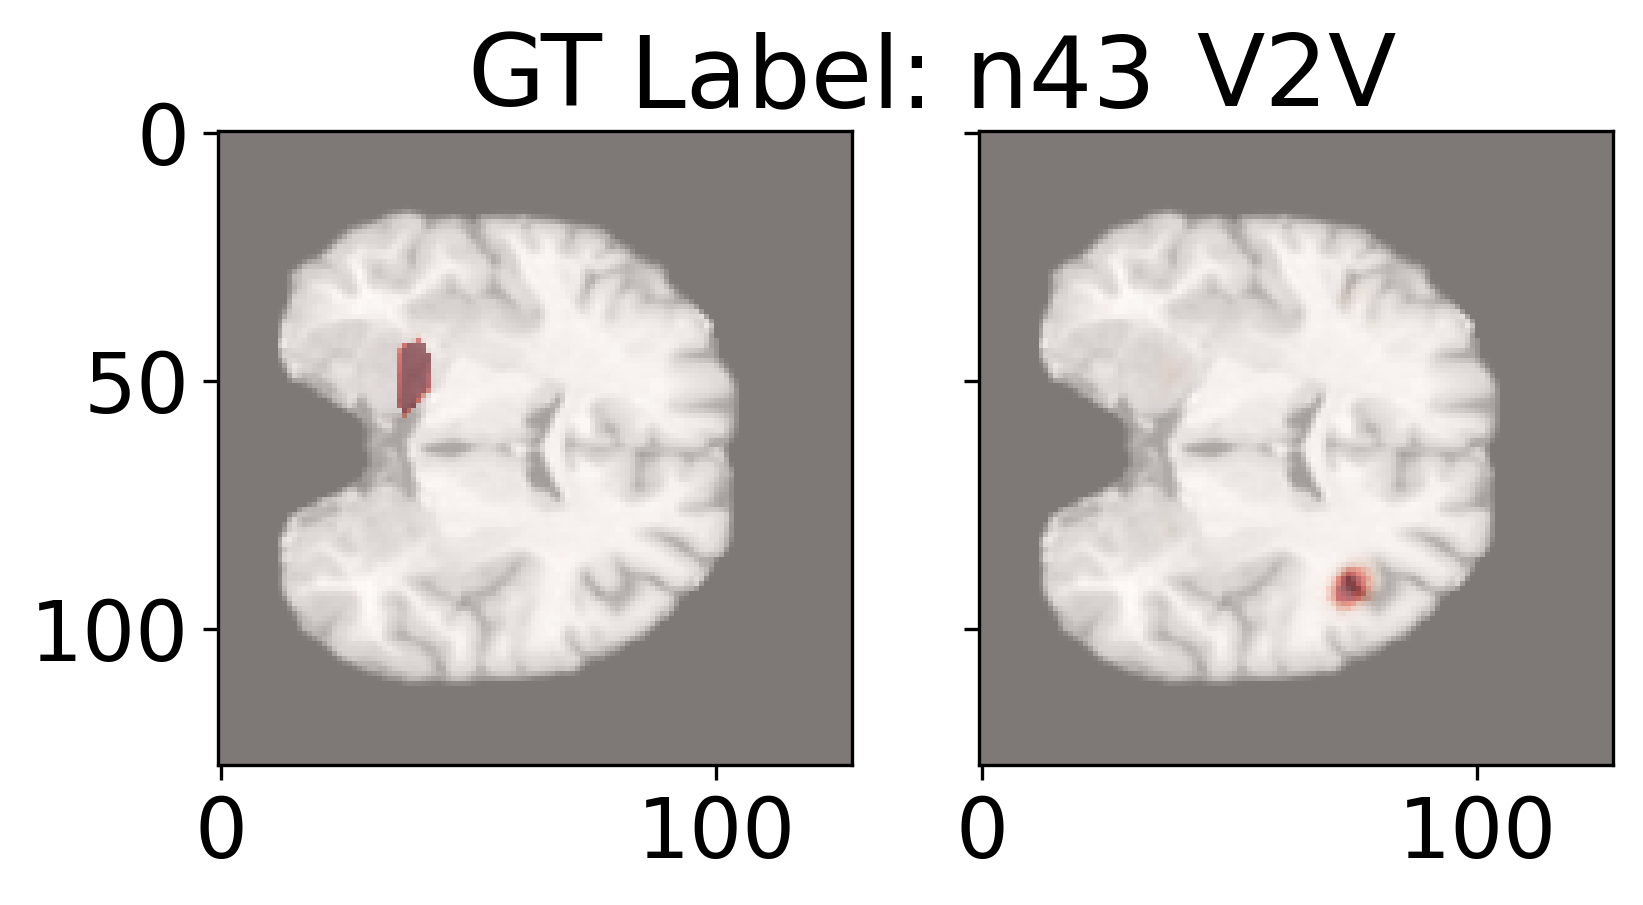

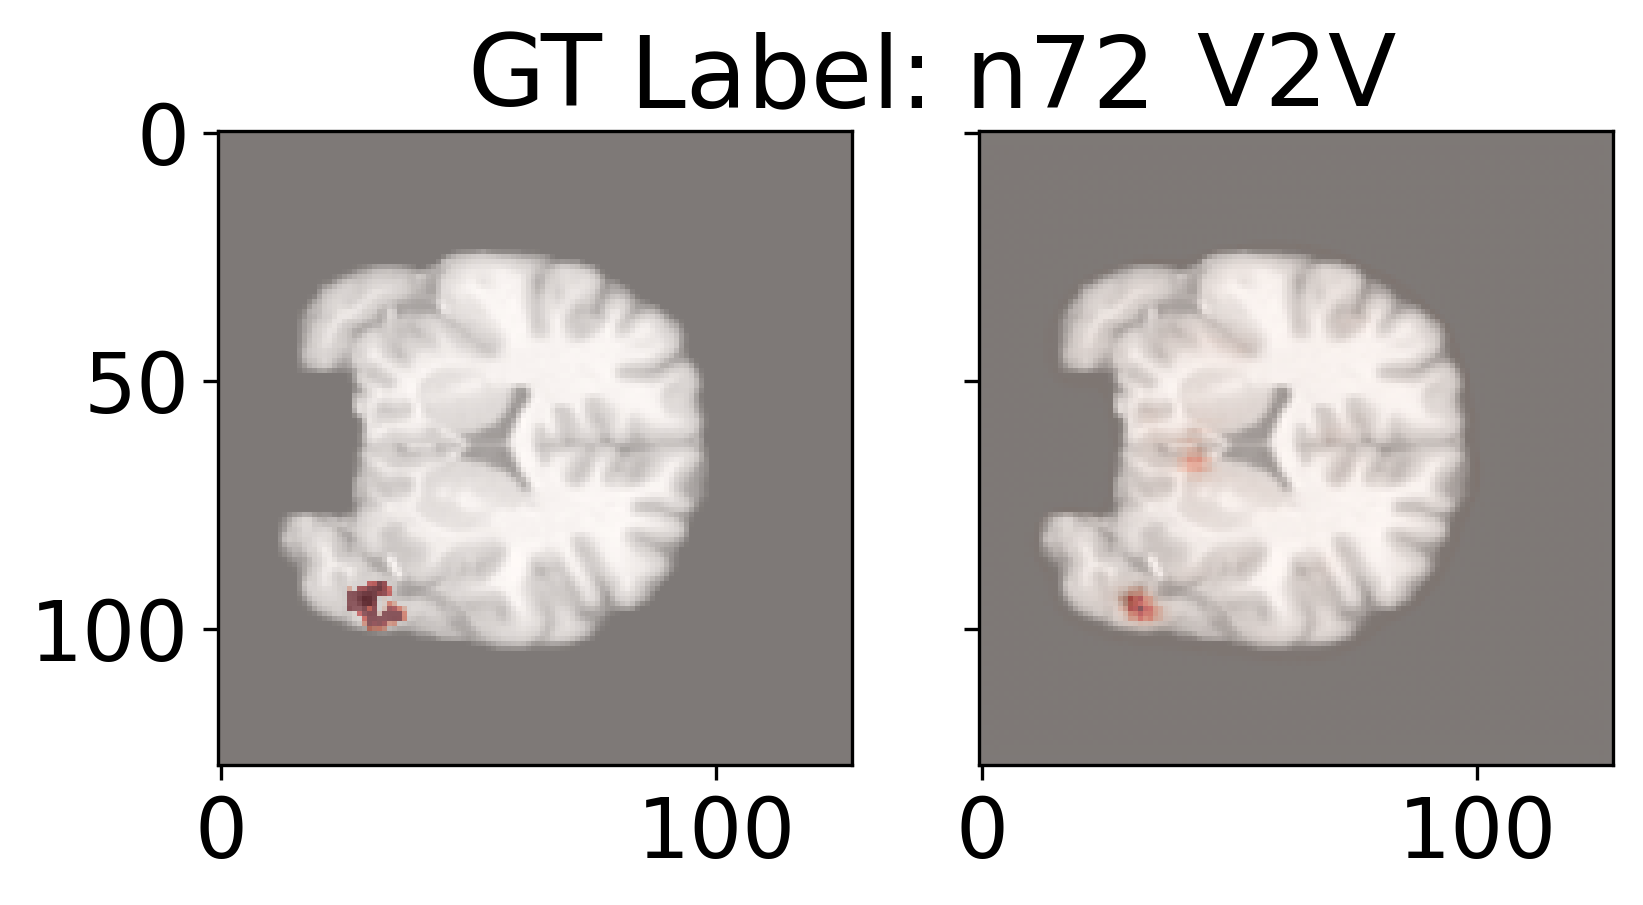

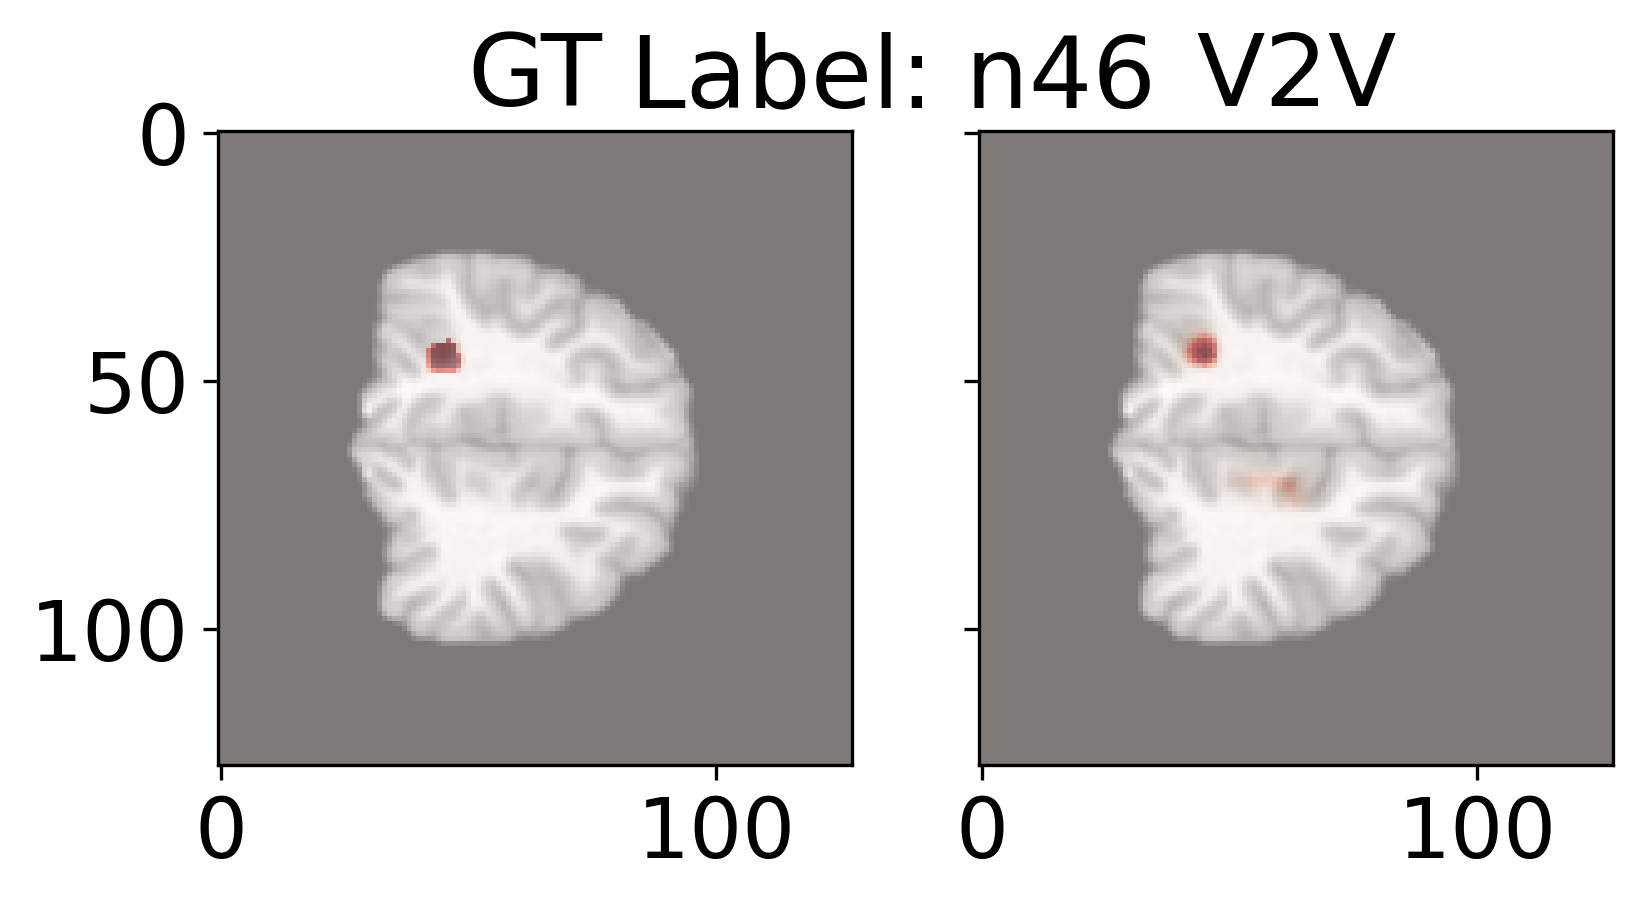

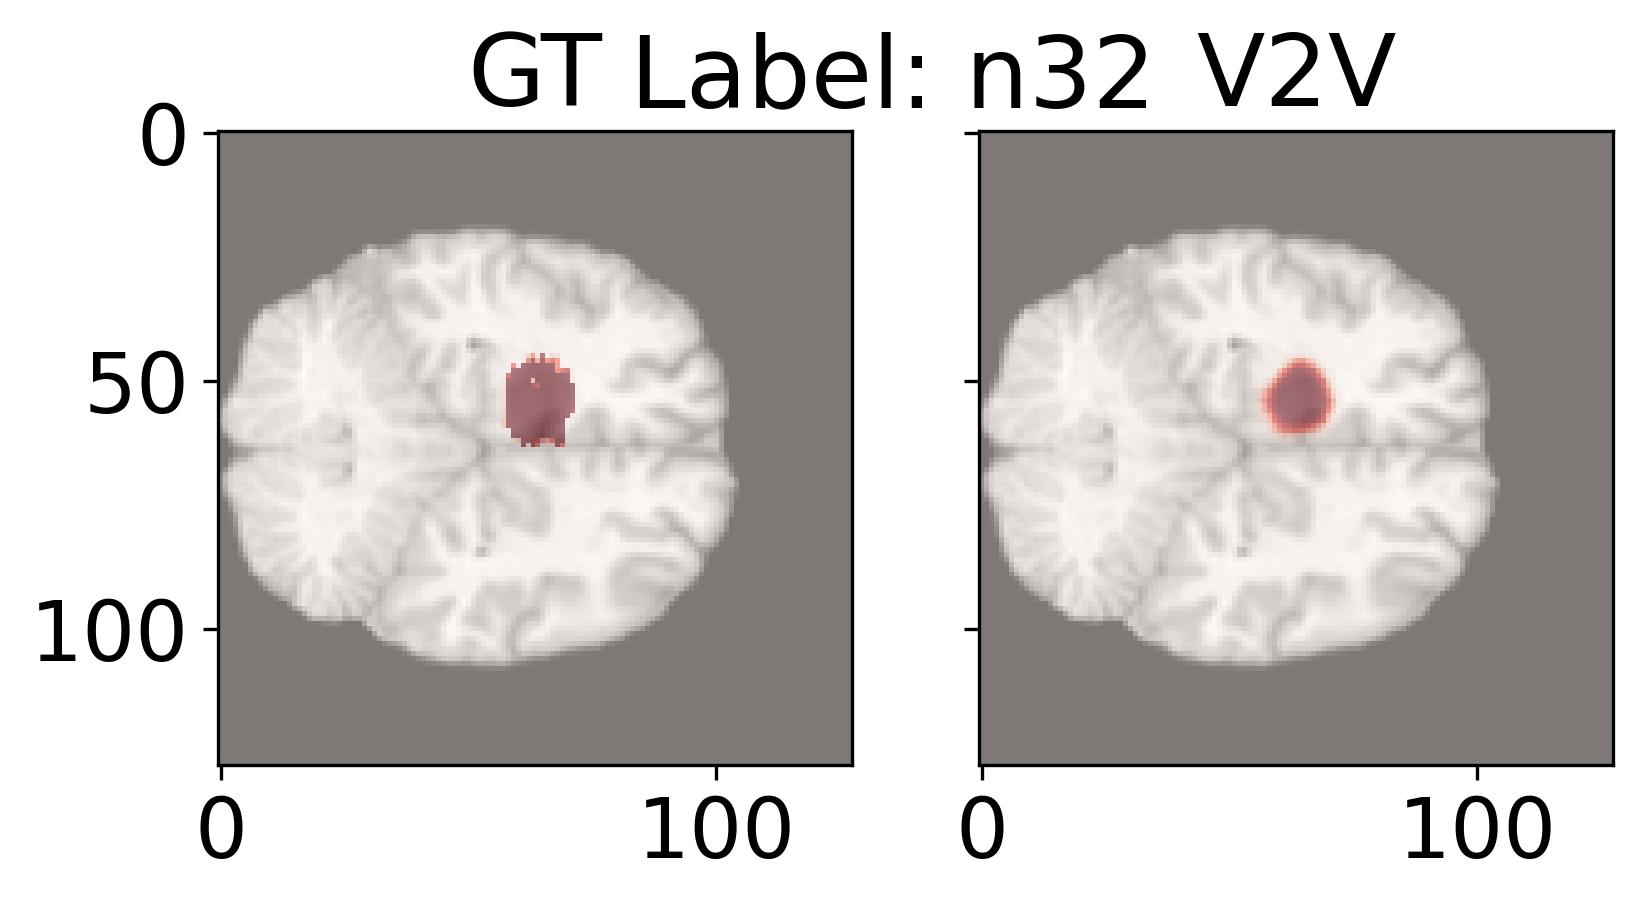

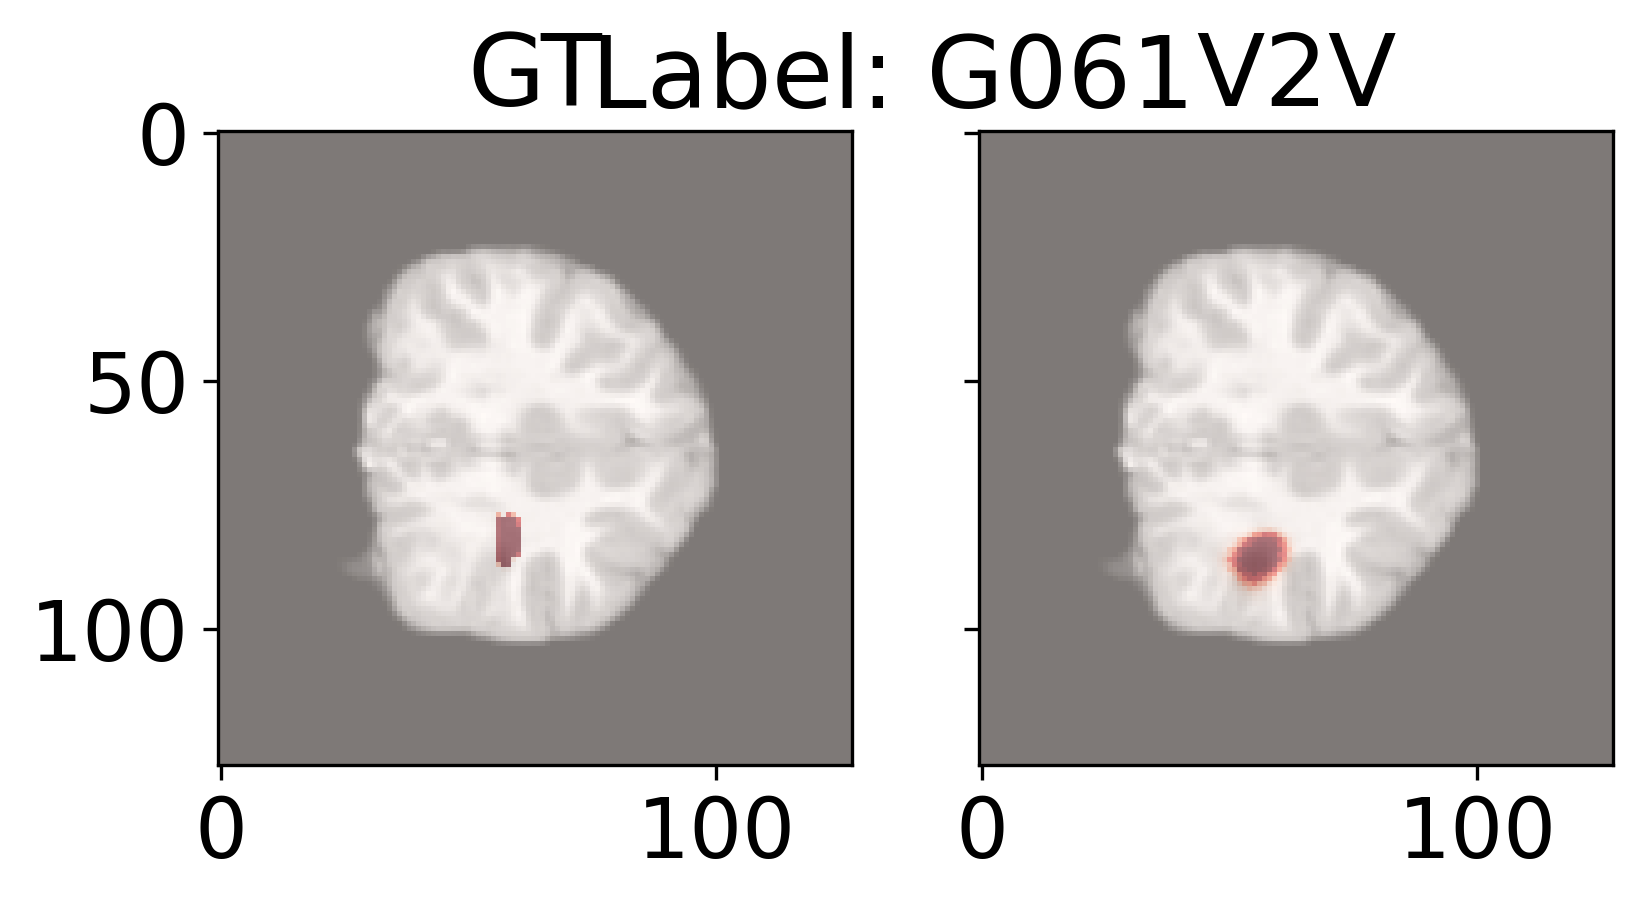

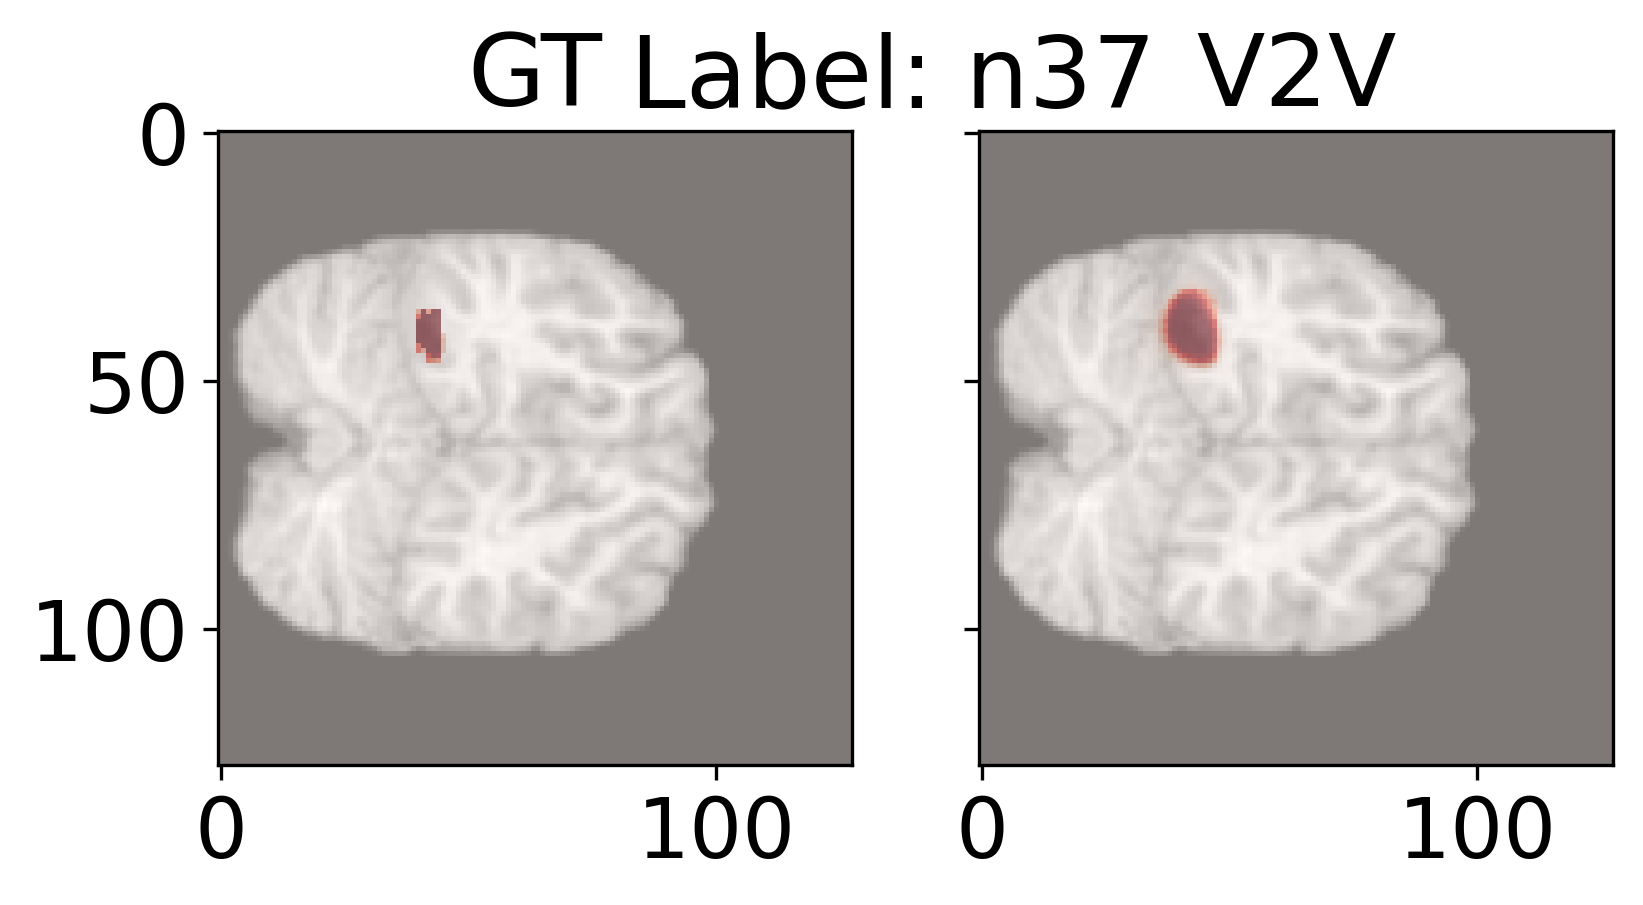

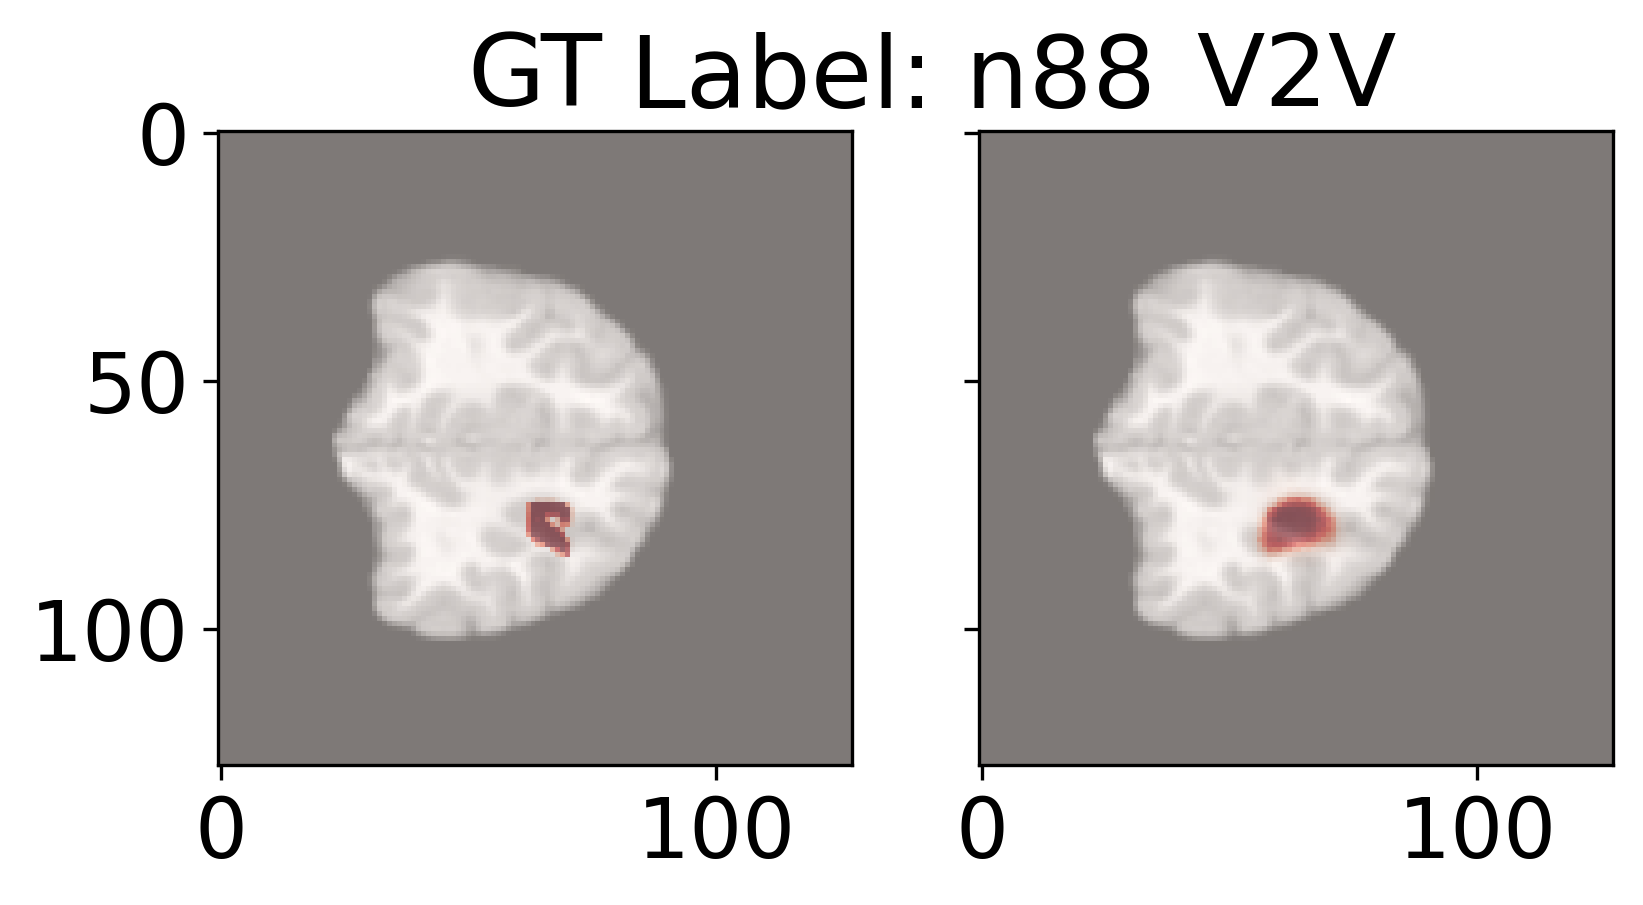

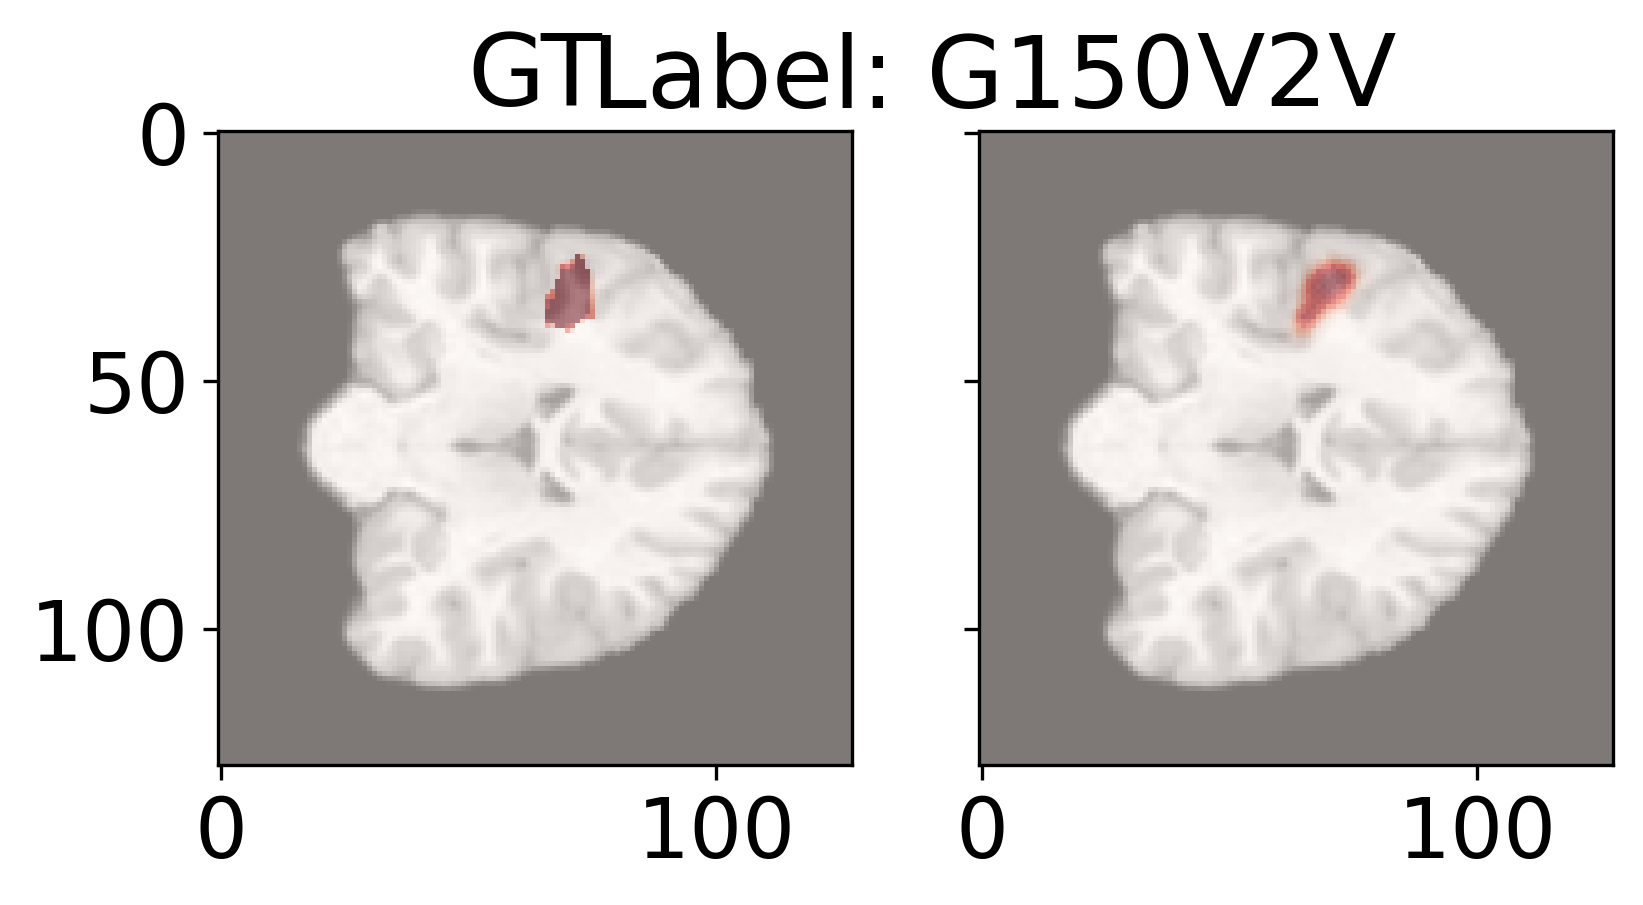

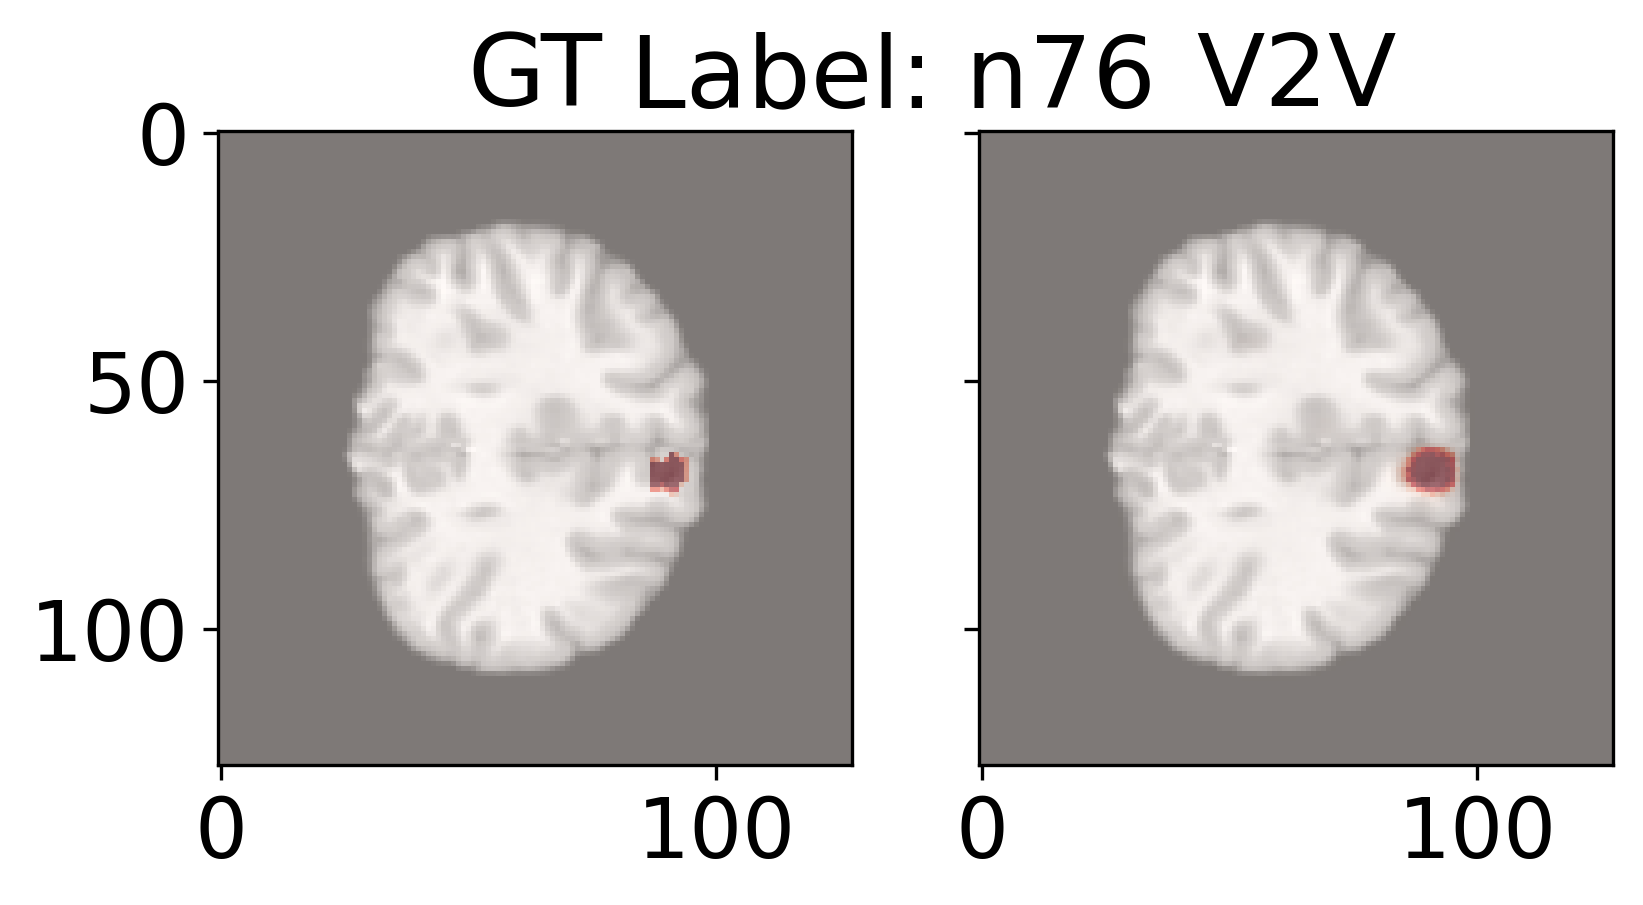

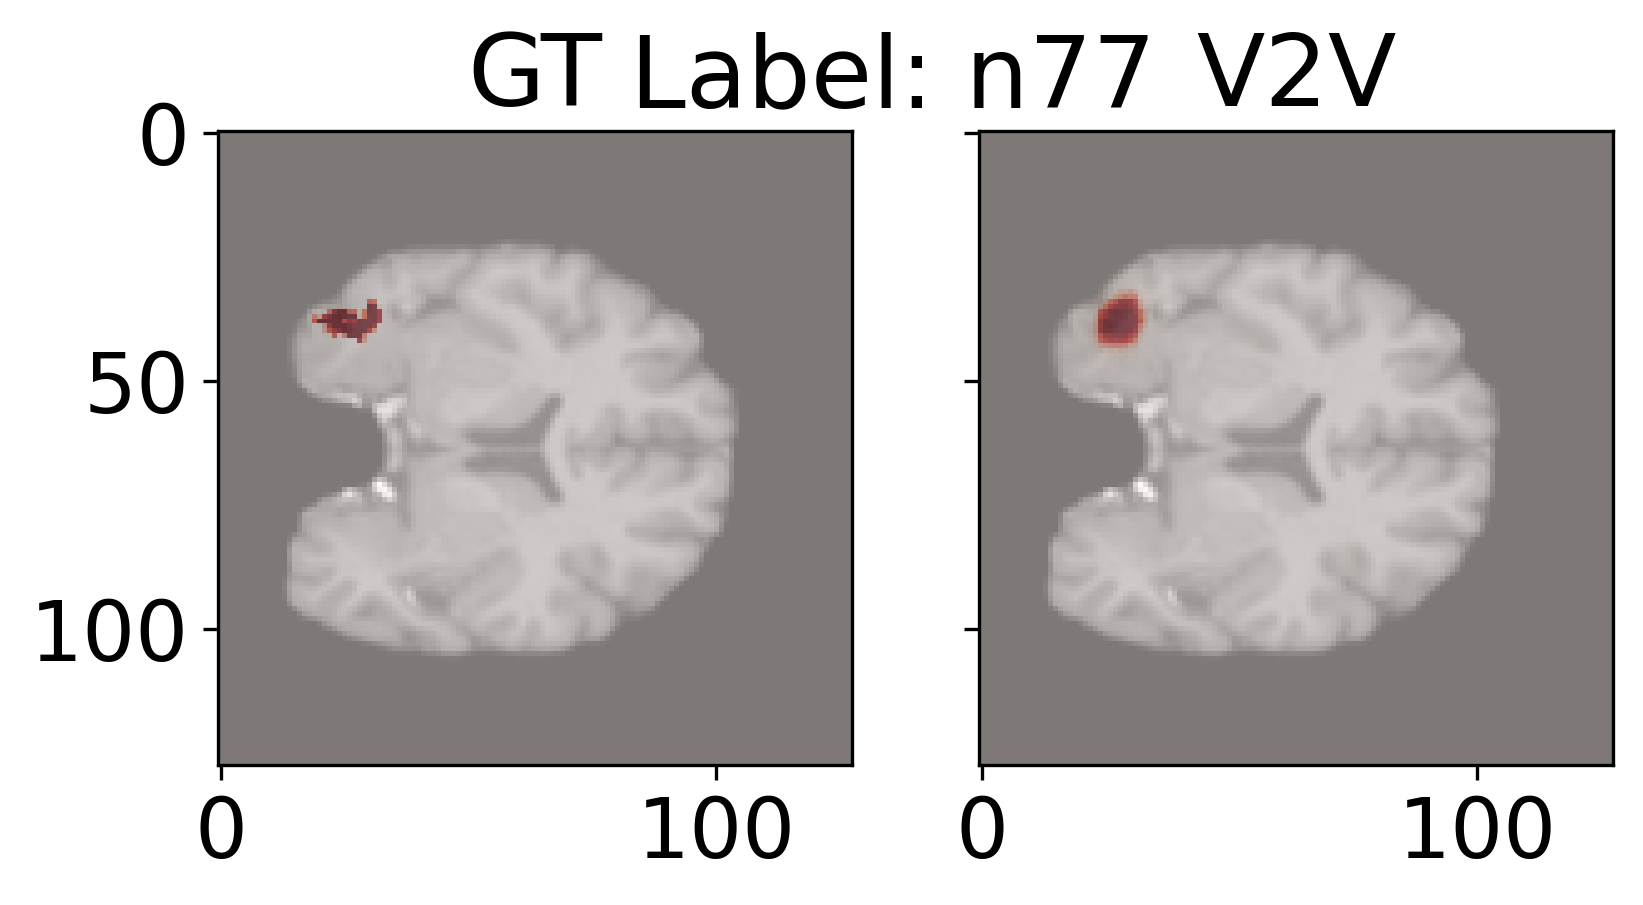

In [55]:
for label in brains.keys():

    brain = brains[label][0]
    label_gt = labels_gt[label]
    label_pred = labels_pred[label]

    fig, ax = plt.subplots(1,2, sharex=True, sharey=True, dpi=300)
    X_max, Y_max, Z_max = brain.shape

    y_slice_pos = label_gt.sum(axis=(0,-1)).argmax()

    brain_slice = brain[:,y_slice_pos,:]
    label_gt_slice = label_gt[:,y_slice_pos,:]
    ax[0].imshow(brain_slice, cmap='gray')
    ax[0].imshow(label_gt_slice, cmap='Reds', alpha=0.5)
    ax[0].set_title('GT')

    label_pred_slice = label_pred[:,y_slice_pos,:].astype(float)
    ax[1].imshow(brain_slice, cmap='gray')
    ax[1].imshow(label_pred_slice, cmap='Reds', alpha=0.5)
    ax[1].set_title('V2V')
    
    fig.suptitle(f'Label: {label}', y=.85)

    plt.show()
    

In [110]:
from batch_metrics import our_metric

ModuleNotFoundError: No module named 'functions'